# Random Forest Classifier 

Random Forest Classifier Steps: <br>
- Load Main Dataset <br>
- Split in Dataset for training and testing <br>
- Build Bootstrapped Dataset <br>
- Train Decision Trees on those datasets using diferent groups of features<br>
- Get Test Data and for each entry on the table make it go through all the trees and take note of the results<br>
- Agregate all the results from the different trees and choose the best value thorugh majority voting<br>
            


## Library imports

In [1]:
import pandas as pd
import numpy as np
import math
import os
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay, explained_variance_score
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint
from matplotlib import pyplot 

from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz


#mainpath="C:\\Users\\alexa\\Desktop\\github\\Project-LabIACD\\metadata.csv"
pylidcpath="C:\\Users\\alexa\\Desktop\\Tudo\\Aulas\\LABS\\Project-LabIACD\\csv\\pylidc_grouped.csv"
pyradiomicsPath="C:\\Users\\alexa\\Desktop\\Tudo\\Aulas\\LABS\\Project-LabIACD\\csv\\Dataset_cleared.csv"

## Load Pylidc Dataset

In [63]:
main_dataset=pd.read_csv(pylidcpath)
main_dataset.tail()


,Subtlety,Internalstructure,Calcification,Sphericity,Margin,Lobulation,Spiculation,Texture,Malignancy,Malignancy_round
2646,4.333333,1.0,6.0,3.666667,2.333333,2.333333,3.0,3.333333,4.0,4
2647,2.500000,1.0,6.0,4.500000,2.000000,1.000000,1.5,1.000000,3.5,4
2648,3.000000,1.0,6.0,3.500000,3.500000,1.500000,1.0,5.000000,3.5,4
2649,5.000000,1.0,6.0,4.000000,5.000000,1.000000,1.0,5.000000,2.0,2
2650,5.000000,1.0,4.0,5.000000,5.000000,3.000000,3.0,5.000000,2.5,3


## Spliting Training and Testing Datasets

We are firstly going to make the data division based on Pareto´s Law (80% training/20% testing) <br>

In [64]:
collumn_name='Malignancy_round'
features_collumns=main_dataset.drop(collumn_name,axis=1)
features_collumns=features_collumns.drop('Malignancy',axis=1)
has_cancer_collumns=main_dataset[collumn_name]

features_treino, features_teste, has_cancer_treino, has_cancer_teste=train_test_split(features_collumns,has_cancer_collumns, test_size=0.2)
#has_cancer_collumns
#features_collumns

## Random Forest Classifier Pylidc

Although we say in the index that we have to build the Bootstrapped Dataset the sklearn random forest classifier has the ability to do that for us alowing us to skip a step<br>
<br>
In this chapter we´ll have some sub-chapters so that we can play around with the random Forest Classifier to try and get the best possible model


### Default Random Forest

#### DataFitting

In [4]:
RandomForest = RandomForestClassifier()
RandomForest.fit(features_treino,has_cancer_treino)

RandomForestClassifier()

#### Model Evaluation

##### Prediction Part

In [5]:
has_cancer_prediction=RandomForest.predict(features_teste)

##### Accuracy Part

In [6]:
#accuracy= explained_variance_score(has_cancer_teste, has_cancer_prediction)
accuracy = accuracy_score(has_cancer_teste, has_cancer_prediction)
print(f"Accuracy = {accuracy} in a percentage of 100 = {accuracy*100}")

Accuracy = 0.6064030131826742 in a percentage of 100 = 60.64030131826742


### Model Tuning

Now let's see if by changing the parameters we can get a better solution<br>
<br>
With sklearn we have some comands that help us with this such as RandomizedSearchCV, but let´s first talk about the parameters we'll be messing with:<br>
- n_estimators: Represents the amount of Decision Trees in our Forest, we'll try to change the value in increments of 20 to try and find an "optimal" value between [50,400]<br>
- criterion: criterion in the trees we'll be testing gini vs entropy<br>
- max_features: the number of features that each tree will have, according to some studies the best values should be around $\sqrt{TotalFeatures}$ or log<sub>2</sub>(TotalFeatures)<br>
- min_samples_split: that represents the minimum samples to split a node<br>
- max_depth: in changing this value we can optimize our model and reduce the risk of overfitting

<br>


#### Stackable Improvements Assumption

Note that this is only one proposal of a potential model for this problem where we are going to make some assumptions in order to find if those a are true.
<br>
The first of those is that we'll make the superficial and perhaps stupid assumption that if a parameter improves the accuracy when adjusted by himself that, the improvement is going to stack with the improvement that we get from tuning other parameter by themselfs.<br>
<br>
By the end we'll see if this assumption holds or not

##### Finding the best Tree number

- For this we'll test the tree numbers in increments of 10 <br>
- Our accuracy score for each number of trees will be given by an average of 5 tests <br>
- After this we'll save the best value<br>

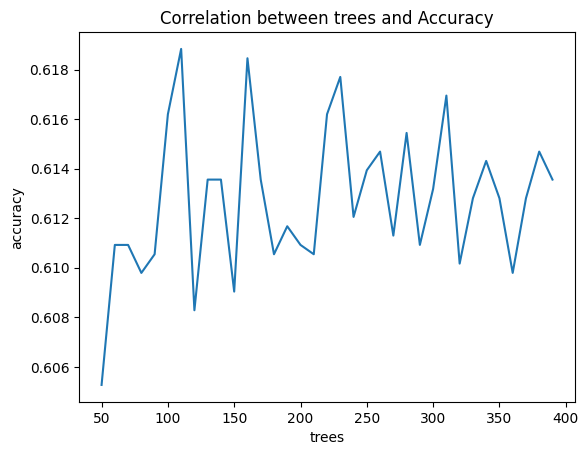

Best tree value=110 accuracy = 0.6188323917137476


In [7]:
a=50
b=400
values=[]
treenumber=[]
for i in range (a,b,10):
    average_accuracy=0

    for k in range (5):
        RandomForesttree = RandomForestClassifier(n_estimators=i, n_jobs=(-1))
        RandomForesttree.fit(features_treino,has_cancer_treino)
        has_cancer_predictiontree=RandomForesttree.predict(features_teste)
        accuracy = accuracy_score(has_cancer_teste, has_cancer_predictiontree)
        average_accuracy+=accuracy
    values.append(average_accuracy/5)
    treenumber.append(i)

pyplot.plot(treenumber,values )
pyplot.xlabel('trees')
pyplot.ylabel('accuracy') 
pyplot.title('Correlation between trees and Accuracy')
pyplot.show() 

values=np.array(values)
index=np.where(values==np.max(values))
besttree=treenumber[index[0][0]]
print(f"Best tree value={besttree} accuracy = {np.max(values)}")

##### Finding the best criterion

We'll test three criterion:<br>
- Gini<br>
- Entropy<br>
- Log Loss

In [8]:
accuracy_gini=0
accuracy_entropy=0
accuracy_logloss=0
for i in range (5):
    RandomForestGini = RandomForestClassifier(criterion="gini", n_jobs=(-1))
    RandomForestGini.fit(features_treino,has_cancer_treino)
    has_cancer_predictionGini=RandomForestGini.predict(features_teste)
    accuracy_gini_iter = accuracy_score(has_cancer_teste, has_cancer_predictionGini)
    accuracy_gini+=accuracy_gini_iter

    RandomForestEntropy = RandomForestClassifier(criterion="entropy", n_jobs=(-1))
    RandomForestEntropy.fit(features_treino,has_cancer_treino)
    has_cancer_predictionEntropy=RandomForestEntropy.predict(features_teste)
    accuracy_entropy_iter = accuracy_score(has_cancer_teste, has_cancer_predictionEntropy)
    accuracy_entropy+=accuracy_entropy_iter

    RandomForestlogloss = RandomForestClassifier(criterion="log_loss", n_jobs=(-1))
    RandomForestlogloss.fit(features_treino,has_cancer_treino)
    has_cancer_predictionlogloss=RandomForestlogloss.predict(features_teste)
    accuracy_logloss_iter = accuracy_score(has_cancer_teste, has_cancer_predictionlogloss)
    accuracy_logloss+=accuracy_logloss_iter

accuracy_gini=accuracy_gini/5
accuracy_entropy=accuracy_entropy/5
accuracy_logloss=accuracy_logloss/5

bestcriterionacc=(np.max([accuracy_entropy, accuracy_gini, accuracy_logloss]))
if bestcriterionacc==accuracy_gini:
    bestcriterionname='gini'
if bestcriterionacc==accuracy_entropy:
    bestcriterionname='entropy'
if bestcriterionacc==accuracy_logloss:
    bestcriterionname='log_loss'

In [9]:
print(f"Accuracy Gini = {accuracy_gini} in a percentage of 100 = {accuracy_gini*100}")
print(f"Accuracy Entropy = {accuracy_entropy} in a percentage of 100 = {accuracy_entropy*100}")
print(f"Accuracy Log Loss = {accuracy_logloss} in a percentage of 100 = {accuracy_logloss*100}")
print(f"Best criterion = {bestcriterionname} with an accuracy of = {bestcriterionacc}")

Accuracy Gini = 0.6124293785310735 in a percentage of 100 = 61.24293785310735
Accuracy Entropy = 0.608286252354049 in a percentage of 100 = 60.8286252354049
Accuracy Log Loss = 0.6150659133709981 in a percentage of 100 = 61.50659133709981
Best criterion = log_loss with an accuracy of = 0.6150659133709981


##### Finding the best minimum samples split

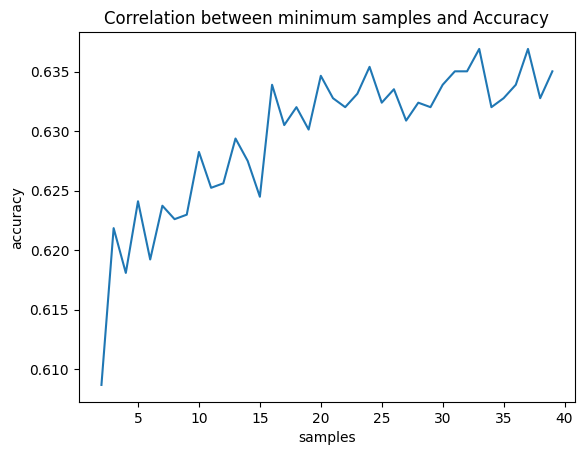

Best Sample value=33, max accuracy=0.6369114877589455


In [10]:
lower=2
upper=40
values=[]
samplesnumber=[]
for i in range (lower,upper):
    average_accuracy=0

    for k in range (5):
        RandomForestSamples = RandomForestClassifier(min_samples_split=i, n_jobs=(-1))
        RandomForestSamples.fit(features_treino,has_cancer_treino)
        has_cancer_predictionsamples=RandomForestSamples.predict(features_teste)
        accuracy = accuracy_score(has_cancer_teste, has_cancer_predictionsamples)
        average_accuracy+=accuracy
    values.append(average_accuracy/5)
    samplesnumber.append(i)
    
pyplot.plot(samplesnumber,values )
pyplot.xlabel('samples')
pyplot.ylabel('accuracy') 
pyplot.title('Correlation between minimum samples and Accuracy')
pyplot.show()


values=np.array(values)
index=np.where(values==np.max(values))
bestsample=samplesnumber[index[0][0]]
print(f"Best Sample value={bestsample}, max accuracy={np.max(values)}")


##### Finding the best Tree deepth

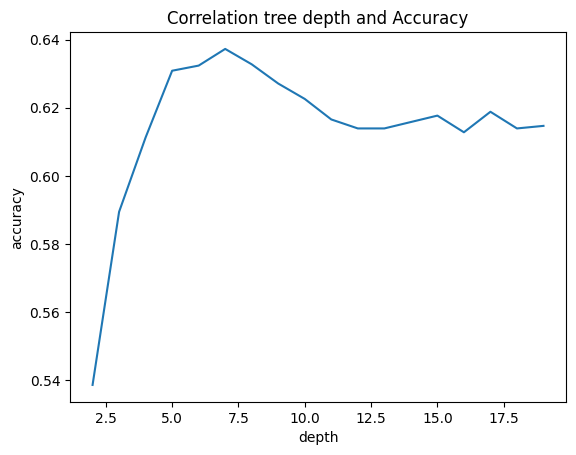

Best depth value=7, max accuracy=0.6372881355932203


In [11]:
lower=2
upper=20
values=[]
depthnumber=[]
for i in range (lower,upper):
    average_accuracy=0

    for k in range (5):
        RandomForestdepth = RandomForestClassifier(max_depth=i, n_jobs=(-1))
        RandomForestdepth.fit(features_treino,has_cancer_treino)
        has_cancer_predictiondepth=RandomForestdepth.predict(features_teste)
        accuracy = accuracy_score(has_cancer_teste, has_cancer_predictiondepth)
        average_accuracy+=accuracy
    values.append(average_accuracy/5)
    depthnumber.append(i)



pyplot.plot(depthnumber,values )
pyplot.xlabel('depth')
pyplot.ylabel('accuracy') 
pyplot.title('Correlation tree depth and Accuracy')
pyplot.show()

values=np.array(values)
index=np.where(values==np.max(values))
bestdepthnumber=depthnumber[index[0][0]]
print(f"Best depth value={bestdepthnumber}, max accuracy={np.max(values)}")

##### Finding the best Max Features

In this we have two options $\sqrt{TotalFeatures}$ or log<sub>2</sub>(TotalFeatures), that have been shown by studies to be the best two value.<br> But these two values tend to be very similar unless TotalFeatures is a high number. 

In [12]:
accuracy_sqr=0
accuracy_log=0
for i in range (5):
    RandomForestsqr = RandomForestClassifier(max_features='sqrt', n_jobs=(-1))
    RandomForestsqr.fit(features_treino,has_cancer_treino)
    has_cancer_predictionsqr=RandomForestsqr.predict(features_teste)
    accuracy_sqr_iter = accuracy_score(has_cancer_teste, has_cancer_predictionsqr)
    accuracy_sqr+=accuracy_sqr_iter

    RandomForestlog = RandomForestClassifier(max_features='log2', n_jobs=(-1))
    RandomForestlog.fit(features_treino,has_cancer_treino)
    has_cancer_predictionlog=RandomForestlog.predict(features_teste)
    accuracy_log_iter = accuracy_score(has_cancer_teste, has_cancer_predictionlog)
    accuracy_log+=accuracy_log_iter

accuracy_sqr=accuracy_sqr/5
accuracy_log=accuracy_log/5

best_maxsamples_acc=(np.max([accuracy_sqr, accuracy_log,]))
if best_maxsamples_acc==accuracy_sqr:
    best_max_samples_name='sqrt'
if best_maxsamples_acc==accuracy_log:
    best_max_samples_name='log2'

print(f"Accuracy Sqr= {accuracy_sqr} in a percentage of 100 = {accuracy_sqr*100}")
print(f"Accuracy Log= {accuracy_log} in a percentage of 100 = {accuracy_log*100}")
print(f"Difference = {abs(accuracy_log-accuracy_sqr)}")
print(f"Best Max Samples = {best_max_samples_name} with an accuracy of = {best_maxsamples_acc}")

Accuracy Sqr= 0.6112994350282486 in a percentage of 100 = 61.12994350282486
Accuracy Log= 0.6048964218455744 in a percentage of 100 = 60.48964218455743
Difference = 0.006403013182674222
Best Max Samples = sqrt with an accuracy of = 0.6112994350282486


##### Model with "optimal stacking"

In [32]:
accuracy_optimal=0
for i in range(5):
    RandomForestoptimal = RandomForestClassifier(n_estimators=besttree, criterion=bestcriterionname, min_samples_split=bestsample, max_features=bestsample, max_depth=bestdepthnumber, n_jobs=(-1))
    RandomForestoptimal.fit(features_treino,has_cancer_treino)
    has_cancer_predictionoptimal=RandomForestoptimal.predict(features_teste)
    accuracy_optimal_iter = accuracy_score(has_cancer_teste, has_cancer_predictionoptimal)
    accuracy_optimal+=accuracy_optimal_iter
accuracy_optimal=accuracy_optimal/5

print (f"Optimal stacking model accuracy = {accuracy_optimal}")

Optimal stacking model accuracy = 0.6100864553314121


###### Confusion Matrix "optimal stacking"

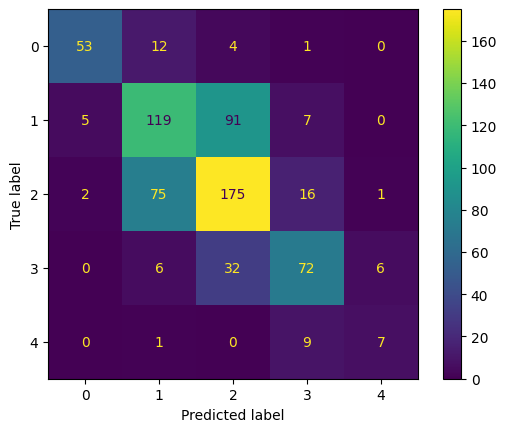

In [33]:
cm=confusion_matrix(has_cancer_teste, has_cancer_predictionoptimal)
ConfusionMatrixDisplay(confusion_matrix=cm).plot()

###### First Tree from "optimal stacking" model

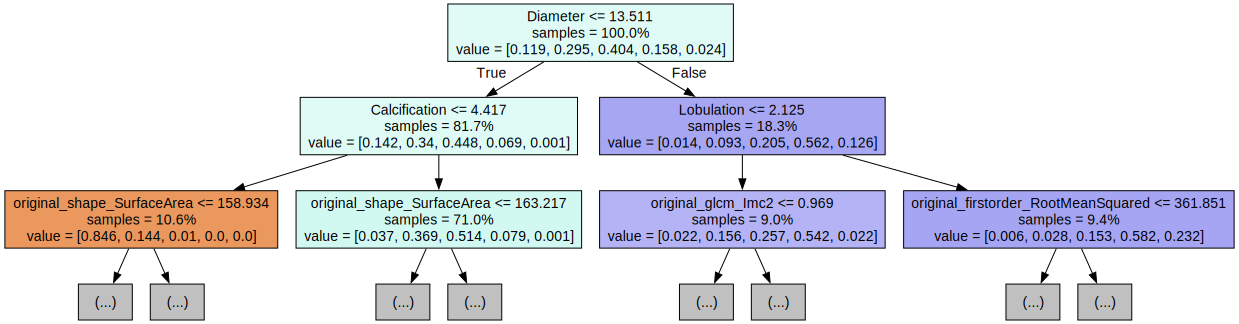

In [34]:
tree = RandomForestoptimal.estimators_[i]
dot_data = export_graphviz(tree,
                            feature_names=features_treino.columns,  
                            filled=True,  
                            max_depth=2, 
                            impurity=False, 
                            proportion=True)
graph = graphviz.Source(dot_data)
display(graph)

##### Proposal conclusions

Since the accuracy of the model with the stacked optimal parameters is lower than the accuracy of the tuning of some individual parameters we can safelly say that stacking the best parameters isn't a good idea and the "optimal" value for a parameter can change depending on the value of other parameters.<br>
<br>
But we can also say that due to the "optimal stacking" model accuracy beeing higher than the default we can also assume that changing the parameters even if with a bad proposal it's better than leaving them with the default values<br>
<br>
We've also seen that due to the above test beeing done with only 8 features that it limits in various aways the model for exemple the difference between the square root of 8 and the log of base 2 of 8 is 0.2 and beeing that you can't choose 0.2 of a feature the trees had the same exact number of features in both of those tests making the difference 0 wich also doesn't allows us to know the effects of both.<br>
<br>
Also the low number of features renders usseles the efforts of increasing the amount of trees in the forest, because if it chooses let's say the square root of x, beeing x the total number of features that in this case is 8 there is only about 300 different ways to structure a tree with those 3 features picked at random per tree and of those 300 trees alot of them will be overfit, which explains why in none of the tests runned the best tree number was higher than 220.

#### The computer is Smarter Assumption

Let's now give the computer ability to test diferent parameters at random to find the best parameters<br>
<br>



##### Create the Dictionary for the range of values on the parameters

In [65]:
Range = {'n_estimators': randint(50,500), 
              'max_depth': randint(1,20), 
              'criterion': ['gini', 'entropy', 'log_loss'], 
              'min_samples_split': randint(2,50), 
              'max_features': ['sqrt','log2']
              }

print(Range)

{'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001D6FD28D7D0>, 'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001D6816E75D0>, 'criterion': ['gini', 'entropy', 'log_loss'], 'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001D6FB015750>, 'max_features': ['sqrt', 'log2']}


##### Random Search

In [66]:
RandomSearch = RandomizedSearchCV(RandomForest, param_distributions = Range, n_iter=5, n_jobs=(-1))


###### Training the Model

In [67]:
RandomSearch.fit(features_treino, has_cancer_treino)

RandomizedSearchCV(estimator=RandomForestClassifier(), n_iter=5, n_jobs=-1,
                   param_distributions={'criterion': ['gini', 'entropy',
                                                      'log_loss'],
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001D6816E75D0>,
                                        'max_features': ['sqrt', 'log2'],
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001D6FB015750>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001D6FD28D7D0>})

###### Best parameters found 

In [68]:
Best_Random_Search = RandomSearch.best_estimator_
print('Best hyperparameters:',  RandomSearch.best_params_)

Best hyperparameters: {'criterion': 'log_loss', 'max_depth': 15, 'max_features': 'log2', 'min_samples_split': 17, 'n_estimators': 320}


###### Accuracy of this model

In [69]:
has_cancer_prediction_BestRandomSearch = Best_Random_Search.predict(features_teste)
accuracy_BestRandomSearch = accuracy_score(has_cancer_teste, has_cancer_prediction_BestRandomSearch)
print(accuracy_BestRandomSearch)

0.6591337099811676


###### Confusion Matrix

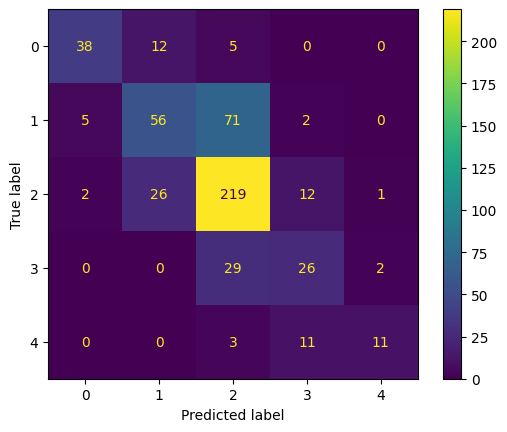

In [70]:
cmrandom=confusion_matrix(has_cancer_teste, has_cancer_prediction_BestRandomSearch)
ConfusionMatrixDisplay(confusion_matrix=cmrandom).plot()

##### Assumption conclution and findings

Before the conclusion just a little find for our model:<br>
In regards to time: Total_time ≈ Number_of_iterations * 0,561 (in the computer that ran the code)<br>
<br>
This method was in fact better than the previous model, but it still is no where perfect or good, 66% of accuracy although better is still far from good<br>
I think that this model still suffers from the same problems as the other that beeing the lack of features that pylidc provides.<br>
<br>
Also We've found out that more itterations doesn't always correlate to a better outcome due to the randomness of it, you can find sometimes a better model with less iterations if you are just lucky enough.<br>
<br>



## Load Pyradiomics Dataset

In [71]:
main_dataset=pd.read_csv(pyradiomicsPath)
main_dataset.tail()

,original_shape_Flatness,original_shape_LeastAxisLength,original_shape_MajorAxisLength,original_shape_Maximum2DDiameterColumn,original_shape_Maximum2DDiameterRow,original_shape_Maximum2DDiameterSlice,original_shape_Maximum3DDiameter,original_shape_MeshVolume,original_shape_MinorAxisLength,original_shape_Sphericity,...,Volume,Subtlety,Internalstructure,Calcification,Sphericity,Margin,Lobulation,Spiculation,Texture,Malignancy
2646,0.375133,4.534490,12.087678,12.806248,11.401754,13.928388,14.628739,313.083333,9.595771,0.664923,...,140.178680,4.333333,1.0,6.0,3.666667,2.333333,2.333333,3.0,3.333333,4.0
2647,0.687954,8.589183,12.485120,14.422205,14.317821,12.649111,15.165751,605.541667,9.416961,0.697558,...,182.381630,2.500000,1.0,6.0,4.500000,2.000000,1.000000,1.5,1.000000,4.0
2648,0.185778,2.586515,13.922612,11.045361,14.866069,12.165525,15.842980,177.541667,7.855304,0.597379,...,127.207670,3.000000,1.0,6.0,3.500000,3.500000,1.500000,1.0,5.000000,4.0
2649,0.247844,2.471175,9.970706,7.280110,7.211103,7.615773,10.440307,70.041667,4.521458,0.708770,...,81.383582,5.000000,1.0,6.0,4.000000,5.000000,1.000000,1.0,5.000000,2.0
2650,0.273192,11.674262,42.732887,49.040799,50.219518,46.097722,51.048996,13760.916667,38.858918,0.635278,...,25205.225767,5.000000,1.0,4.0,5.000000,5.000000,3.000000,3.0,5.000000,2.0


## Random Forest Classifier Pyradiomics

Let's now test the theory that if we had more features it would be better, as we proposed in the Pylidc part of this notebook.<br>
With Pyradiomics we were able to extract about 100 features to train our model.<br>

### Data Split 1

In [72]:
features_collumns=main_dataset.drop('Malignancy',axis=1)
has_cancer_collumns=main_dataset['Malignancy']

features_treino, features_teste, has_cancer_treino, has_cancer_teste=train_test_split(features_collumns,has_cancer_collumns, test_size=0.2)

### Random Forest Pyradiomics 1

We will be doing two random forests for pyradiomics<br>
The first we will use to get an estimate of the maximum complexity of one tree in a forest for the second data split

#### Random Search and data fitting

In [79]:
RandomSearch = RandomizedSearchCV(RandomForest, param_distributions = Range, n_iter=5, n_jobs=(-1))
RandomSearch.fit(features_treino, has_cancer_treino)
Best_Random_Search = RandomSearch.best_estimator_
print('Best hyperparameters:',  RandomSearch.best_params_)

Best hyperparameters: {'criterion': 'gini', 'max_depth': 14, 'max_features': 'log2', 'min_samples_split': 13, 'n_estimators': 194}


#### Accuracy

In [80]:
has_cancer_prediction_BestRandomSearch = Best_Random_Search.predict(features_teste)
accuracy_BestRandomSearch = accuracy_score(has_cancer_teste, has_cancer_prediction_BestRandomSearch)
print(accuracy_BestRandomSearch)

0.5725047080979284


#### Confusion Matrix

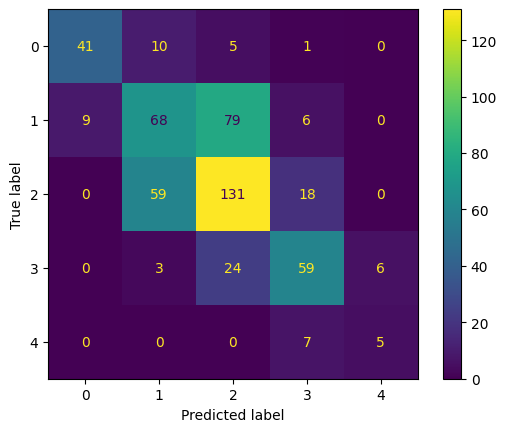

In [81]:
cmrandom=confusion_matrix(has_cancer_teste, has_cancer_prediction_BestRandomSearch)
ConfusionMatrixDisplay(confusion_matrix=cmrandom).plot()

### Data Split 2

We'll use the "A scaling law
for the validation-set training-set size ratio" paper by Isabelle Guyon findings to try and optimize our data split or an adaptation of the findings to our case.<br>
In the paper it's said that the best split is given by $\sqrt{}$ ln($\frac{N}{hmax}$)<br>
N beeing the number of families of recognizers in an finite H<br>
hmax beeing the largest complexity of those families<br>
<br>

So for our random forest we are going to do a small adaptation in the hopes that it improves the accuracy:<br>
- N is going to be the number of trees in the forest<br>
- hmax the complexity of the trees.<br>
<br>
We'll use the tree from pyradiomics random forest 1 to make the calculations<br>


#### Setting N

In [82]:
N=RandomSearch.best_params_['n_estimators']
print(N)

194


#### Setting hmax

The complexity of one tree is determined by bigO(tkd) beeing:<br>
- t: number training examples<br>
- k: number of features<br>
- d: depth of decision tree<br>


In [83]:
t=RandomSearch.best_params_['min_samples_split']
if (RandomSearch.best_params_['max_features']=='sqrt'):
    k=math.sqrt(117)
else:
    k=math.log(117)

d=RandomSearch.best_params_['max_depth']


hmax=t*k*d
hmax=hmax
print (f"hmax={hmax} t={t} k={k} d={d}")

hmax=866.7156561331917 t=13 k=4.762173934797756 d=14


#### Setting $\sqrt{}$ ln($\frac{N}{hmax}$)

In [84]:
result=N/hmax*100000
result=math.trunc(result)/100000
print(result)
log=abs(math.log(result))
print(log)
split=math.sqrt(result)
print(split)

0.22383
1.4968684438306044
0.47310675328090596


#### Spliting with new split value

In [85]:
features_collumns=main_dataset.drop('Malignancy',axis=1)
has_cancer_collumns=main_dataset['Malignancy']

features_treino, features_teste, has_cancer_treino, has_cancer_teste=train_test_split(features_collumns,has_cancer_collumns, test_size=split)

### Random Forest Pyradiomics 2

#### Random Forest with same hyperparameters

In [86]:
RandomSearch.fit(features_treino, has_cancer_treino)


RandomizedSearchCV(estimator=RandomForestClassifier(), n_iter=5, n_jobs=-1,
                   param_distributions={'criterion': ['gini', 'entropy',
                                                      'log_loss'],
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001D6816E75D0>,
                                        'max_features': ['sqrt', 'log2'],
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001D6FB015750>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001D6FD28D7D0>})

#### Accuracy

In [87]:
has_cancer_prediction_BestRandomSearch = Best_Random_Search.predict(features_teste)
accuracy_BestRandomSearch = accuracy_score(has_cancer_teste, has_cancer_prediction_BestRandomSearch)
print(accuracy_BestRandomSearch)

0.8414342629482072


#### Confusion Matrix

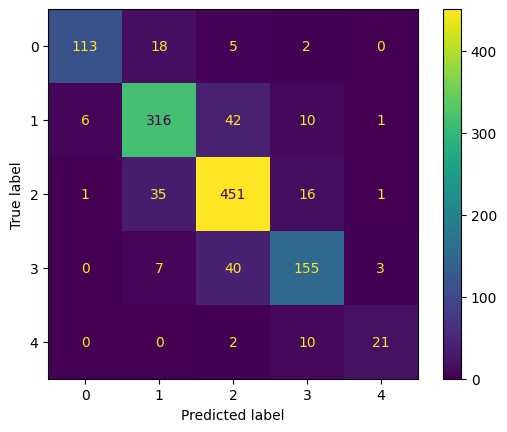

In [88]:
cmrandom=confusion_matrix(has_cancer_teste, has_cancer_prediction_BestRandomSearch)
ConfusionMatrixDisplay(confusion_matrix=cmrandom).plot()

### Conclusions for pyradiomics data

In this chapter we explored the accuracy of a Random Search Random Forest model applied to our pyradiomics extracted features and we also experimented with new data splits.<br>
We can say that the problem that we thought was holding our model back in the random forest pylidc chapter (the lack of features) was not a real problem, because giving the model more features doesn't always mean better results, because data quality also matters, and with the 117 features we gave the model now that a big part of them were probably irrelevant and ended up only adding to the confusion of our model.<br>
So we came to the conclusion that our Pylidc models were all beter than our pyradiomic one but when we adjusted the data split the accuracy of the pyradiomics increased by a lot in most of the runs of the code with some exceptions where it only increased a bit.<br>
Other findings that we had were that the number of trees in the forest with this much features tends to be higher that in the pylidc model.<br>
<br>
In our new data split test we found out that calculating the data split this new way using $\sqrt{}$ ln($\frac{N}{hmax}$) improved our accuracy even if by a samll amount in the various runs of the code we did, so we can assume that improving the split is improving data quality.

## Final Notes

We would also like to add that we also tested the random forest with the assumption of if malignancy>3 then its considered cancer and less than 3 is considered non cancer, and with the data spliting method proposed by Isabelle Guyon we reached 0.9993 accuracy. We have decided to discard this because assuming that something thats Moderately Suspicious is in fact cancer is already a reach.<br>
In other words it might lead to a higher accuracy in the paper but in reality we think that it would add a inaccuracy to pacient diagnostics<br>
Some other notes we took is that the data split by Isabelle Guyon still improved accuracy by 4% from 95% to 99%<br>
<br>
Due to the discarding of this assumption we didn't include it in this notebook, but all the values and accuracy numbers are still possible to visit in the BinaryRandomForest.ipynb notebook, the notebook doesn't have any conclusions because we discarded it but it still might be worth it to check the values
